## Work
1. 請嘗試寫一個 callback 用來記錄各類別在訓練過程中，對驗證集的 True Positive 與 True Negative

In [1]:
import os
from tensorflow import keras
import numpy as np

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
# 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preproc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

model = build_mlp(input_shape=x_train.shape[1:])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 256)               786688    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 hidden_layer2 (Dense)       (None, 256)               65792     
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 hidden_layer3 (Dense)       (None, 256)               65792 

In [6]:
# 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
# 載入 Callbacks
from keras.callbacks import Callback

# Record_fp_tp
class Record_tp_tn(Callback):
    def __init__(self, val_data):
        self.validation_data = val_data
        
    def on_epoch_end(self, epoch, logs={}):
        y_true = self.validation_data[1].argmax(axis = 1)
        y_pred = self.model.predict(self.validation_data[0])

        y_pred = y_pred.argmax(axis=1)
        
        for i in range(10):
            val_tp = np.sum((y_true == i) & (y_pred == i))
            logs[f"val_tp_{i}"] = val_tp
        
rec_tptn = Record_tp_tn(val_data=(x_test, y_test))

In [8]:
optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

history = model.fit(x_train, y_train, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_data=(x_test, y_test), 
                    shuffle=True,
                    callbacks=[rec_tptn], 
                    verbose=1)

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

valid_tp = {}
for i in range(10):
    valid_tp[f"val_tp_{i}"] = model.history.history[f"val_tp_{i}"]

Epoch 1/25
49/49 [==============================] - 5s 90ms/step - loss: 2.2566 - accuracy: 0.2636 - val_loss: 2.1493 - val_accuracy: 0.2158 - val_tp_0: 290.0000 - val_tp_1: 11.0000 - val_tp_2: 314.0000 - val_tp_3: 167.0000 - val_tp_4: 16.0000 - val_tp_5: 171.0000 - val_tp_6: 156.0000 - val_tp_7: 9.0000 - val_tp_8: 712.0000 - val_tp_9: 312.0000
Epoch 2/25
49/49 [==============================] - 4s 78ms/step - loss: 1.7732 - accuracy: 0.3831 - val_loss: 2.0045 - val_accuracy: 0.2808 - val_tp_0: 380.0000 - val_tp_1: 73.0000 - val_tp_2: 166.0000 - val_tp_3: 207.0000 - val_tp_4: 74.0000 - val_tp_5: 480.0000 - val_tp_6: 139.0000 - val_tp_7: 166.0000 - val_tp_8: 593.0000 - val_tp_9: 530.0000
Epoch 3/25
49/49 [==============================] - 3s 66ms/step - loss: 1.6380 - accuracy: 0.4271 - val_loss: 1.8481 - val_accuracy: 0.3575 - val_tp_0: 528.0000 - val_tp_1: 207.0000 - val_tp_2: 242.0000 - val_tp_3: 251.0000 - val_tp_4: 159.0000 - val_tp_5: 436.0000 - val_tp_6: 418.0000 - val_tp_7: 261.

Epoch 25/25
49/49 [==============================] - 5s 101ms/step - loss: 1.0525 - accuracy: 0.6416 - val_loss: 1.4451 - val_accuracy: 0.4968 - val_tp_0: 637.0000 - val_tp_1: 574.0000 - val_tp_2: 388.0000 - val_tp_3: 321.0000 - val_tp_4: 338.0000 - val_tp_5: 397.0000 - val_tp_6: 557.0000 - val_tp_7: 561.0000 - val_tp_8: 624.0000 - val_tp_9: 571.0000


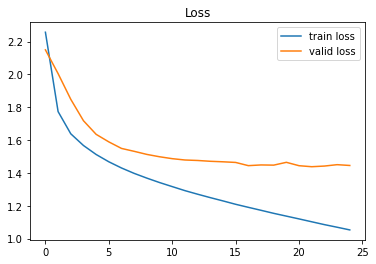

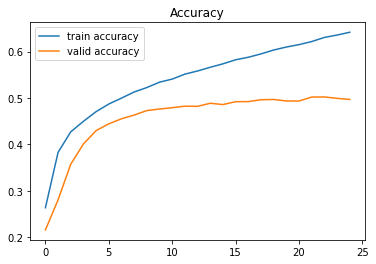

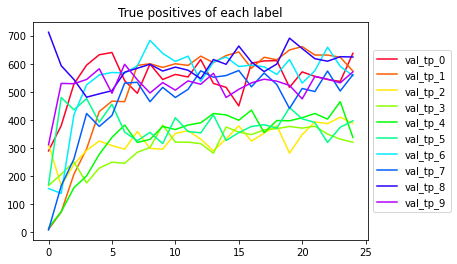

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.figure()
plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

NUM_COLORS = len(valid_tp.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure()
for i, cond in enumerate(valid_tp.keys()):
    plt.plot(range(len(valid_tp[cond])), valid_tp[cond], label=cond, color=color_bar[i])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("True positives of each label")
plt.show()